
# Sentence Classifier
Here we train a BERT classifier that classifies sentences as said by "Michael" or "Other". At first, we used it to find the character that his sentences can be distinguished from others, which is Michael in our case. This classifier will be later used to evaluate how good was our style transfer method.

All additional packages:

In [4]:
!pip install --q transformers
!pip install --q sentence_transformers
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.0/727.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 58.8 MB/s eta 0:00:00


In [2]:
! rm -rf NLP-project
! git clone https://github.com/ReviBa/NLP-project
! cp -rf NLP-project/* .

Cloning into 'NLP-project'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 177 (delta 87), reused 113 (delta 33), pack-reused 0
Receiving objects: 100% (177/177), 9.67 MiB | 7.23 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [5]:
from t5.train import t5_train
from utils.tokens_utils import get_tokenizer_based_on_data, get_max_tokens_number
from t5.model import T5Model
from classifier.utils import freeze_bert_top_layers
from classifier.data_preperation import prepare_data

In [6]:
# general
import os
import csv
import random
import warnings

# ML
import numpy as np
import pandas as pd

# visual
import matplotlib
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt

# DL
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

# HF
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup

# SK
from sklearn import metrics as ms
from sklearn.model_selection import train_test_split

Set warnings filter to ignore:

In [7]:
warnings.filterwarnings('ignore')

Download the transcript dataset

In [8]:
file_path = "/content/NLP-project/resources/The-Office-Lines-V4.csv"

In [9]:
CHARACTER = "Michael"

In [10]:
full_df = pd.read_csv(file_path)

df = full_df[full_df.speaker == CHARACTER]

df['line'] = df['line'].map(str.lower)

**Sentences classification**

In [11]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'

In [12]:
torch.cuda.empty_cache()

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
character_to_classify = ['Michael']

DF aduption and training

In [15]:
class_df = full_df[['speaker','line']]

In [16]:
for idx, row in class_df.iterrows():
  if row['speaker'] not in character_to_classify:
    row['speaker'] = 'other'

In [17]:
class_df.speaker.unique()

array(['Michael', 'other'], dtype=object)

In [18]:
from numpy.random import default_rng

arr_indices_top_drop = default_rng().choice(class_df[class_df.speaker != 'Michael'].index, size=30000, replace=False)
class_df = class_df.drop(index=arr_indices_top_drop)
class_df.shape

(24626, 2)

In [19]:
# filter row with empty lines
class_df['line'].replace('', np.nan, inplace=True)
class_df['line'].replace(' ', np.nan, inplace=True)
class_df['line'].replace('  ', np.nan, inplace=True)

class_df.dropna(subset=['line'], inplace=True)

In [20]:
# shuffle
class_df = class_df.sample(frac=1)

In [21]:
df_train, df_test = train_test_split(class_df ,test_size = 0.2, random_state=100)

In [22]:
label2id = {label:id for id,label in enumerate(character_to_classify + ['other'])}
id2label = {value:key for key,value in label2id.items()}

In [23]:
label2id

{'Michael': 0, 'other': 1}

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [25]:
train_sequences = prepare_data(df_train, label2id, tokenizer, 256)
test_sequences = prepare_data(df_test, label2id, tokenizer, 256)

In [26]:
len(train_sequences.dataset), len(test_sequences.dataset)

(19698, 4925)

In [27]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = len(id2label),
    output_attentions = False,
    output_hidden_states = False)

model.to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Freeze layers in bert

In [28]:
top_layer_params = freeze_bert_top_layers(model)

In [29]:
optimizer = Adam(top_layer_params, lr=0.0001)

In [30]:
def training(model, n_epochs, train_data, dev_data, optimizer=None, criterion=None, debug=False):

  dataloaders = {"train": train_data, "dev": dev_data}
  metrics = {'loss':{'train':[], 'dev':[]}, 'accuracy':{'train':[], 'dev':[]} }

  criterion = nn.CrossEntropyLoss()
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_sequences) * n_epochs)

  for epoch in tqdm(range(n_epochs)):

    if debug:
      print('Epoch {}/{}'.format(epoch+1, n_epochs))
      print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'dev']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      running_loss = 0.0   # total loss of the network at each epoch
      running_corrects = 0 # number of correct predictions
      total_sentences = 0

      # Iterate over data.
      for inputs, pad_mask, labels in tqdm(dataloaders[phase]):

        inputs = inputs.to(DEVICE)
        pad_mask = pad_mask.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):

          outputs = model(inputs, attention_mask=pad_mask).logits
          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            #print('moved step')

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels)
        total_sentences += len(labels)

      epoch_loss = running_loss / len(dataloaders[phase])
      epoch_acc = running_corrects.double() / total_sentences

      metrics['loss'][phase] = epoch_loss
      metrics['accuracy'][phase] = epoch_acc

      if debug:
        print(' {} Loss: {:.4f}  |  Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

  return metrics

In [ ]:
epochs = 13
metric = training(model, epochs, train_data=train_sequences, dev_data=test_sequences, optimizer=optimizer, debug=True)

In [ ]:
# Use only to load pretrained weights
checkpoint = torch.load('/content/drive/MyDrive/classifier_on_michael_bert.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

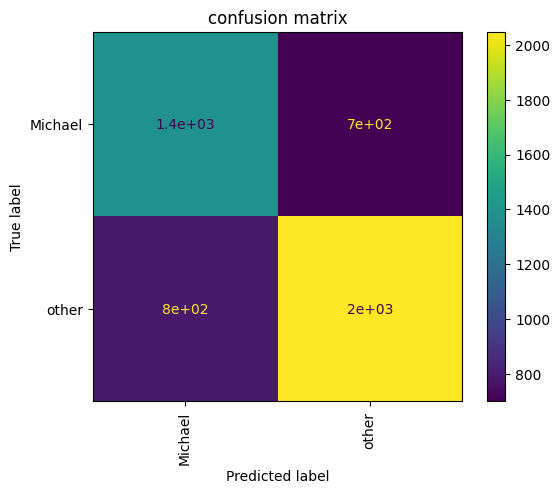

+---------+-------------+----------+--------+-----------+
|         |   PERCISION |   RECALL |     F1 |   SUPPORT |
|---------+-------------+----------+--------+-----------|
| Michael |      0.6639 |   0.6350 | 0.6491 | 2178.0000 |
| other   |      0.7203 |   0.7452 | 0.7325 | 2747.0000 |
+---------+-------------+----------+--------+-----------+


,PERCISION,RECALL,F1,SUPPORT
Michael,0.663946,0.634986,0.649143,2178
other,0.720267,0.745177,0.732510,2747


In [ ]:
labels = list(label2id.keys())

def evaluate(model, test_data):
  num_labels = len(id2label)
  confusion_mat = np.zeros((num_labels,num_labels))
  total_preds = total_labels = torch.Tensor([]).to(DEVICE)

  for inputs, pad_mask, labels_batch in test_data:

    inputs = inputs.to(DEVICE)
    pad_mask = pad_mask.to(DEVICE)
    labels_batch = labels_batch.to(DEVICE)

    with torch.no_grad():
        outputs = model(inputs, pad_mask).logits
        _, preds = torch.max(outputs, 1)

        for pred, label in zip(preds, labels_batch):
          confusion_mat[pred, label] += 1

    total_labels = torch.cat((total_labels, labels_batch))
    total_preds = torch.cat((total_preds, preds))

  # print confusion matrix with 'other'
  disp = ms.ConfusionMatrixDisplay(confusion_mat, display_labels=labels)
  disp.plot()
  disp.ax_.set_title("confusion matrix")
  disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(), rotation=90)
  plt.show()

  # generate RECALL-PERCISION-F1 tabel
  precision, recall, f1, support = ms.precision_recall_fscore_support(total_labels.cpu(), total_preds.cpu(), average=None, labels=list(label2id.values()))
  df = pd.DataFrame(columns=['PERCISION','RECALL','F1','SUPPORT'])
  df.PERCISION = precision
  df.RECALL = recall
  df.F1 = f1
  df.SUPPORT = support
  df.index = labels
  print(tabulate(df, headers='keys', tablefmt='psql',floatfmt=".4f"))

  return df

evaluate(model, test_sequences)